Classifying images as containing hindi alphabets or not

In [ ]:
#Importing necessary libraries

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,Input, Lambda, Dense, Flatten, Dropout, MaxPool2D
from keras.models import Model

# I have used transfer learning models from keras applications and, i was able to get the higher accuracy with InceptionResNetV2

#from keras.applications.vgg16 import VGG16
#from keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionResNetV2
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications import NASNetLarge
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras.applications.InceptionResNetV2

ERROR: Could not find a version that satisfies the requirement keras.applications.InceptionResNetV2 (from versions: none)
ERROR: No matching distribution found for keras.applications.InceptionResNetV2


In [ ]:
IMAGE_SIZE = [150, 150]

train_path = 'training'
valid_path = 'test'

In [ ]:
incResnet = InceptionResNetV2(input_shape=(150,150,3), weights='imagenet', include_top=False)

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
for layer in incResnet.layers:
    layer.trainable = False

In [ ]:
folders = glob('training/*')
folders

['training/hi', 'training/background']

In [ ]:
ls

inceptionResNetV2_1.json  model_IncResnetV2_1.h5  training/
IndAcHackathon.ipynb      tester/


In [ ]:
x = Flatten()(incResnet.output)

In [ ]:
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=incResnet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( 
    rescale = 1./255,
    rotation_range=40,
    shear_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    'training',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 5875 images belonging to 2 classes.


In [ ]:
check_set = test_datagen.flow_from_directory('tester',target_size = (75,75))

Found 98 images belonging to 1 classes.


In [ ]:
op = model.fit_generator(
  train_generator,
  epochs=2
) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
184/184 [==============================] - 551s 3s/step - loss: 0.2732 - accuracy: 0.8877
Epoch 2/2
184/184 [==============================] - 551s 3s/step - loss: 0.2443 - accuracy: 0.9011


In [ ]:
def predictImage(filename):
    img1 = image.load_img('tester/test/'+filename,target_size=(150,150))
    Y = image.img_to_array(img1)
    Y=Y/255
    X = model.predict(np.expand_dims(Y,axis=0))
    val = np.where(X > 0.3,1,0)
    res = val.tolist()
    return res[0][0]

In [ ]:
ans=[]
for i in range(98):
    res = predictImage(str(i+1)+'.jpg')
    ans.append(res)

In [ ]:
sum([i==1 for i in ans])

43

[[0]] [[0.26783365]]


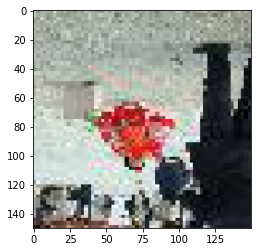

In [ ]:
img1 = image.load_img('tester/test/32.jpg',target_size=(150,150))
plt.imshow(img1)
Y = image.img_to_array(img1)
Y=Y/255
X = model.predict(np.expand_dims(Y,axis=0))
val = np.where(X > 0.3,1,0)
print(val,X)

In [ ]:
import random
import json
# from utils.io import write_json

def write_json(filename, result):
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)

def read_json(filename):
    with open(filename, 'r') as outfile:
        data =  json.load(outfile)
    return data

def generate_sample_file(filename,ans):
    res = {}
    for i in range(1,99):
        test_set = str(i) + '.jpg'
        res[test_set] = ans[i-1]

    write_json(filename, res)

generate_sample_file('./inceptionResNetV2_3(0.3T).json',ans)

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_IncResnetV2_1.h5')